In [ ]:
"""
Name: Sanket Makkar
    CaseID:         sxm1626
    File Name:      dataparsing.ipynb
    Date Created:   12/1/2024
    Description:    This is the data analysis jupyter notebook for project 5. Here is where I define functions and
                    and classes to analyze and parse through collected data (first cell), provide parsed data to 
                    the analyzer class (second cell), execute functions to observe insight 1 (third cell), 
                    insight 2 (fourth cell), insight 3 (fifth cell), insight 4 (sixth cell), and insight five (7th cell)
"""
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math

# separators for data
MEASURE_SEPARATOR = "|--|"
LINE_SEPARATOR = "\n------------------\n"

# prefixes and useful constant strings in our data
LATENCY_PREFIX = "time "
LATENCY_UNITS = "ms"
FAILED_MEASUREMENT = "*"
LATENCY_UNITS_WITH_SPACING_OFFSET = " ms"
SPACING_OFFSET = " "
NEWLINE = "\n"

# helpful basic variables like a counter, offset for off-by-one error avoidance, etc...
COUNTER_INITIAL_VALUE = 0
LAST_IDX = -1
OFF_BY_ONE_OFFSET = 1
BAD_OUTPUT = -1
RESPONSE_STATUS_OK = 200

# positions known to contain data within lists
POPULARITY_POSITION = 0
HOST_POSITION = 1
COUNTRY_POSITION = 2
LATENCY_POSITION = 3
TRACEROUTE_POSITION = 4
BYTES_GRABBED_POSITION = 5

# plotting constants for modifying plt plots
DEGREE_FIT_FOR_LINEAR_RELATIONSHIPS = 1
ROTATE_TICKS_TO_FIT = 90
FIG_HEIGHT = 12
FIG_WIDTH = 14

# statistical and mathematical constants used
FOUR_QUARTILES = 4
SCALE_BY_FOURTH = 1/4
SECOND_QUARTILE_POS_RELATIVE_TO_FIRST_QUARTILE = 2
THIRD_QUARTILE_POS_REALTIVE_TO_FIRST_QUARTILE = 3
NUMBER_SQUARED = 2
FIRST_THREE_QUARTERS = 3/4

# we want to parse the data such that we extract relevant metrics appropriately
class dataParser:
    # give this a file name in the local path (or path to open) for grabbing extracted data
    def __init__(self, dataPath):
        self.dataPath = dataPath
        
    # This is the main function used to grab all relevant data
    def getMetrics(self):
        # all the metrics we care about keeping track of
        popularity = []
        websites = []
        countries = []
        latencies = []
        routeLengths = []
        routeLatencies = []
        bytesGrabbed = []
        
        for chunk in self.getFileChunks():
            # each chunks components
            measures = self.chunkComponents(chunk)
            
            # minimal processing required here, grab information as is
            popularity.append(int(measures[POPULARITY_POSITION]))
            websites.append(measures[HOST_POSITION])
            countries.append(measures[COUNTRY_POSITION])
            bytesGrabbed.append(int(measures[BYTES_GRABBED_POSITION][:LAST_IDX]))
            
            # some processing needed - more complex string manipulations called for these
            latency = self.extractLatency(measures[LATENCY_POSITION])
            latencies.append(latency)
            
            routeLength = self.extractRouteLength(measures[TRACEROUTE_POSITION])
            routeLengths.append(routeLength)
            
            routeLatency = self.extractRouteTimes(measures[TRACEROUTE_POSITION])
            routeLatencies.append(routeLatency)

        return (popularity, websites, countries, latencies, routeLengths, routeLatencies, bytesGrabbed)
    
    # This is a helper to do string manipulation required to grab latency
    def extractLatency(self, latencyString):
        timeIdx = latencyString.index(LATENCY_PREFIX)
        timeEndIdx = latencyString.index(LATENCY_UNITS)
        if timeIdx > LAST_IDX:
            return float(latencyString[timeIdx + len(LATENCY_PREFIX):timeEndIdx])    
        return BAD_OUTPUT
    
    # this is a helper for string manipulation that gets you the route length
    def extractRouteLength(self, routeLengthString):
        return routeLengthString.count(NEWLINE) - OFF_BY_ONE_OFFSET
    
    # this is a helper for the string manipulation that gets you the various times along the network traceroute
    def extractRouteTimes(self, routesString):
        # this gets us set up to ignore the first line of a traceroute output (which is just telling us we are using traceroute)
        routeTimes = []
        firstNewlineIdx = routesString.index(NEWLINE) + len(NEWLINE)
        routeLines = routesString[firstNewlineIdx:LAST_IDX].split(NEWLINE)
        
        # now look through each route timing line
        for route in routeLines:
            # if we did not fail the measurement, look for the bit that specifies timing in ms
            if route[LAST_IDX] != FAILED_MEASUREMENT:
                timingMarker = route.rfind(LATENCY_UNITS_WITH_SPACING_OFFSET)
                routeWithoutTimingMarker = route[:timingMarker]
                timeMarker = routeWithoutTimingMarker.rfind(SPACING_OFFSET) + len(SPACING_OFFSET)
                routeTimes.append(float(route[timeMarker:timingMarker]))
            # if we failed the measurement then just use the last valid route time - we can assume that it holds just as a contingency
            else:
                try:
                    routeTimes.append(routeTimes[LAST_IDX]) # we assume for routes that are not reported, the route time was identical to the last recorded route time
                except:
                    routeTimes.append(COUNTER_INITIAL_VALUE) # and if all else fails we have no choice but to append zero as a default
        return routeTimes
    
    # simple helper method to grab the separate components of each chunk (each measurement set we take)
    # this includes (popularity, hostname, country, ping_out, traceroute_out, curl_out)
    def chunkComponents(self, chunk):
        return chunk.split(MEASURE_SEPARATOR)
    
    # grab each chunk (measurement set we take) from the file
    def getFileChunks(self):
        file = self.fileAsText()
        splitFile = file.split(LINE_SEPARATOR)
        return splitFile[:LAST_IDX] # remove the last lineSeparator of the file
    
    # helper to open a simple text file and output its contents
    def fileAsText(self):
        with open(self.dataPath, 'r') as file:
            fileContents = file.read()
            return fileContents

# now separately from parsing through data, we would like to analyze it all
# this involves making plots, as well as particular statistical measurements
class analyzeData:
    # on init we just save all the metrics from a parsed file into separate self._xyz_ arrays for future reference
    def __init__(self, metrics):
        (self.popularity,
        self.websites,
        self.countries,
        self.latencies,
        self.routeLengths,
        self.routeLatencies,
        self.bytesGrabbed) = metrics
        
        # note that we want to compute latency two ways for safety of calculation - i.e. we want rtt by ping and by traceroute's last output (which gives rtt back to us)
        # to do this we will call a method that updates our latency array with the average of these two ways
        self.computeLatenciesTwoWays()
    
    # This is a simple method to make a more robust latency calculation
    def computeLatenciesTwoWays(self):
        for idx, latency in enumerate(self.latencies):
            currLatency = latency
            self.latencies[idx] = (self.routeLatencies[idx][LAST_IDX] + currLatency)/(OFF_BY_ONE_OFFSET + OFF_BY_ONE_OFFSET)
        
    # this looks at (plots and statistically analyzes) network latency to different countries
    def analyzeNetworkLatencyToCountries(self):
        # make some arrays so that we can average out these latencies by country appropriately
        latenciesOverCountries = {}
        countriesCount = {}
        countriesSpecificData = {}
        
        # first we just grab and organize the latency data
        idxPos = COUNTER_INITIAL_VALUE
        for latency, country in zip(self.latencies, self.countries):
            # and if we have observed a country add to its total
            if country in latenciesOverCountries.keys():
                latenciesOverCountries[country] += latency
                countriesCount[country] += OFF_BY_ONE_OFFSET
                countriesSpecificData[country].append(latency)
            # otherwise define the first value we observe for that country
            else:
                latenciesOverCountries[country] = latency
                countriesCount[country] = OFF_BY_ONE_OFFSET
                countriesSpecificData[country] = [latency]
            idxPos+=OFF_BY_ONE_OFFSET
        
        # now we figure out the deviation in latencies by country
        # and we also convert the sum into a mean
        deviationInLatencies = []
        for country, latency in latenciesOverCountries.items():
            total = latenciesOverCountries[country]
            latenciesOverCountries[country] = total/countriesCount[country] # sum to mean
            # if we can get the deviation then good
            try:
                deviationInLatencies.append(statistics.stdev(countriesSpecificData[country]))
            # otherwise something went wrong - just throw in a zero (assume no deviation for bad measurements)
            except:
                deviationInLatencies.append(COUNTER_INITIAL_VALUE)
            # give the user some output for the deviation
            print(str(country) + " has average latency : " + str(latenciesOverCountries[country]) + " | and stddev : " + str(deviationInLatencies[LAST_IDX]))
        
        # and this is just some standard code to make a bar graph plot with standard deviation represented
        plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
        plt.bar(latenciesOverCountries.keys(), latenciesOverCountries.values(), yerr=deviationInLatencies, capsize=10)
        plt.autoscale()
        plt.xlabel("Countries")
        plt.xticks(rotation=ROTATE_TICKS_TO_FIT)
        plt.ylabel("Average Latencies")
        plt.title("Latency Vs Country")
        plt.show()
    
    # this looks at network latency for various route lengths through the network
    def analyzeNetworkLatencyByRouteLength(self):
        plt.scatter(self.routeLengths, self.latencies)
        plt.xlabel("Route Lengths")
        plt.ylabel("Latencies")
        plt.title("Latency Vs Route Lengths through the network")
        
        #include a line of best fit (line of best fit should be linear here)
        slope, intercept = np.polyfit(self.routeLengths, self.latencies, deg=DEGREE_FIT_FOR_LINEAR_RELATIONSHIPS)
        lineOfBestFit = slope * np.array(self.routeLengths) + intercept # numpy only wants to multiply with a numpy array, so we just make one here
        
        # plot it out
        plt.plot(self.routeLengths, lineOfBestFit, label="line of best fit", color="green")
        plt.autoscale()
        plt.show()
        
        # additionally we should compute some basic stats regarding our scatter plot
        self.statsHelper(self.routeLengths, self.latencies, "Route Lengths", "Latencies")
    
    # now we want to look at how latency changes along a route - in which part (beginning, first 1/2, second 1/2, or end) - is network latency larger/smaller? and how?
    def analyzeLatenciesAlongRoutes(self):
        # so to analyze this in particular we do have to gather information about relative distance to last router in the network
        # so we basically compute the elementwise difference between rtt's to us for all routes - this gives us the rtt to the previous router in the chain
        relativeLatencies = []
        for latencyList in self.routeLatencies:
            microList = [latencyList[COUNTER_INITIAL_VALUE]]
            for latencyIdx in range(OFF_BY_ONE_OFFSET, len(latencyList)):
                microList.append(max(COUNTER_INITIAL_VALUE, latencyList[latencyIdx] - latencyList[latencyIdx - OFF_BY_ONE_OFFSET]))
            relativeLatencies.append(microList)
            
        # then define arrays for each stage we observe
        beginning, firstMiddle, secondMiddle, end = [], [], [], []
        
        # for each latency we grabbed from traceroute
        for latencyList in relativeLatencies:
            # account for lists where the length is not >= 4 (where grabbing first and second halves becomes more complicated)
            if len(latencyList) < FOUR_QUARTILES:
                # take the raw beginning and raw ending values
                beginning.append(latencyList[COUNTER_INITIAL_VALUE])
                end.append(latencyList[LAST_IDX])
                
                # give the first half the same value as beginning by default (in cases of 2, 3 this works pretty nicely)
                firstMiddle.append(latencyList[COUNTER_INITIAL_VALUE])
                if len(latencyList) < FOUR_QUARTILES - OFF_BY_ONE_OFFSET:
                    secondMiddle.append(latencyList[LAST_IDX]) # if two values then just assign the second half the same value as end
                else:
                    secondMiddle.append(latencyList[COUNTER_INITIAL_VALUE + OFF_BY_ONE_OFFSET]) # else give it the middle value
                continue
            
            # otherwise...
            # break this into quartile measurements
            firstQuartile = int(math.floor(len(latencyList)/(FOUR_QUARTILES)))
            secondQuartile = firstQuartile * (SECOND_QUARTILE_POS_RELATIVE_TO_FIRST_QUARTILE)
            thirdQuartile = firstQuartile * (THIRD_QUARTILE_POS_REALTIVE_TO_FIRST_QUARTILE)
            
            # grab the relevant sections
            firstSection = latencyList[COUNTER_INITIAL_VALUE:firstQuartile]
            secondSection = latencyList[firstQuartile:secondQuartile]
            thirdSection = latencyList[secondQuartile:thirdQuartile]
            fourthSection = latencyList[thirdQuartile:LAST_IDX]
            
            # and append appropriately
            beginning.append(statistics.mean(firstSection))
            firstMiddle.append(statistics.mean(secondSection))
            secondMiddle.append(statistics.mean(thirdSection))
            end.append(statistics.mean(fourthSection))
        
        # print the stats for beginning, first 1/2, second 1/2, and end (we just look at median and variance here) over all the traceroute measurements
        print("Beginning : Median = " + str(statistics.median(beginning)) + " : Variance = " + str(statistics.stdev(beginning)))
        print("FirstMiddle : Median = " + str(statistics.median(firstMiddle)) + " : Variance = " + str(statistics.stdev(firstMiddle)))
        print("SecondMiddle : Median = " + str(statistics.median(secondMiddle)) + " : Variance = " + str(statistics.stdev(secondMiddle)))
        print("End : Median = " + str(statistics.median(end)) + " : Variance = " + str(statistics.stdev(end)))
        
        # and a box plot can represent this nicely
        plt.boxplot([beginning, firstMiddle, secondMiddle, end])
        plt.xlabel("Beginning | First Portion of Middle | Second Portion of Middle | End")
        plt.ylabel("Latencies along Network path")
        plt.title("Latency Along Network Paths")
        plt.show()
        
    # Now consider how popularity of a website impacts latency to it
    def analyzeLatencyAlongPopularity(self):
        # this is a simple stats scenario - as we really only care about correlation. That being said, to show the behavior canceling out we also make a quick plot
        # the good news is that we basically have all the formatting we really need done
        plt.scatter(self.popularity, self.latencies, s=OFF_BY_ONE_OFFSET)
        plt.yscale('log')
        plt.xlabel("Popularity (Descending Order)")
        plt.ylabel("Latency")
        plt.title("Latency Considering Website Popularity")
        plt.show()
        
        self.statsHelper(self.popularity, self.latencies, "Popularity Rating", "Latencies", modeX=False)
        
    # Lastly lets consider download size and its impact on latency
    def analyzeDownloadSizeAndLatency(self):
        # so to do that we just want to take an average of latencies for various bytes downloaded
        latenciesForBytes = {}
        countforBytes = {}
        for bytes, latency in zip(self.bytesGrabbed, self.latencies):
            if bytes in latenciesForBytes.keys():
                latenciesForBytes[bytes] += latency
                countforBytes[bytes] += float(COUNTER_INITIAL_VALUE)
            else:
                latenciesForBytes[bytes] = latency
                countforBytes[bytes] = float(COUNTER_INITIAL_VALUE)
        
        # average that out here (sum to average)
        for bytes, latency in latenciesForBytes.items():
            latenciesForBytes[bytes] /= max(countforBytes[bytes], 1)
        
        # now build ourselves a scatterplot
        plt.scatter(latenciesForBytes.keys(), latenciesForBytes.values())
        plt.xlabel("Bytes Downloaded")
        plt.ylabel("Latency")
        plt.title("Download Size's Impact on Latency")
        
        # and include an curve of best fit (we will log the whole thing, then compute line of best fit, and then apply log to that slope!)
        latencyValues = list(latenciesForBytes.values())
        logLatencies = np.log(np.array(latencyValues))
        slope, intercept = np.polyfit(list(latenciesForBytes.keys()), logLatencies, DEGREE_FIT_FOR_LINEAR_RELATIONSHIPS)
        domain = np.linspace(COUNTER_INITIAL_VALUE, max(list(latenciesForBytes.keys())))
        fit = np.exp(slope * domain) * np.exp(intercept)
        
        plt.ylim((COUNTER_INITIAL_VALUE, statistics.mean(self.latencies) * (OFF_BY_ONE_OFFSET + OFF_BY_ONE_OFFSET)))
        plt.plot(domain, fit, color="green")
        plt.show()
        
        # and grab some useful stats
        print("ALL BYTES")
        self.statsHelper(self.bytesGrabbed, self.latencies, "Downloaded Bytes", "Latencies", covariance=False)
        
        print("\nFirst 3/4 BYTES")
        threeFourthsIdxBytesGrabbed = int(FIRST_THREE_QUARTERS * len(self.bytesGrabbed))
        threeFourthsIdxLatencies = int(FIRST_THREE_QUARTERS * len(self.latencies))
        self.statsHelper(
            self.bytesGrabbed[:threeFourthsIdxBytesGrabbed], 
            self.latencies[:threeFourthsIdxLatencies],
            "First 3/4 Downloaded Bytes",
            "First 3/4 Latencies",
            covariance=False
        )

        print("\nLast 1/4 BYTES")
        self.statsHelper(
            self.bytesGrabbed[threeFourthsIdxBytesGrabbed:],
            self.latencies[threeFourthsIdxLatencies:],
            "Last 1/4 Downloaded Bytes",
            "Last 1/4 Latencies",
            covariance=False
        )
        
    # this is a helper method designed to do a whole bunch of statistical measurements and print the results
    # all you do is provide the x value array, y value array, and the names you are giving to X, Y respectively
    # if you want to disable a measurement being printed just set the optional parameter for that measurement to False
    # Otherwise you will get by default: Correlation, Standard Deviation, Mode for X values, Mode for Y Values, Covariance, Median of Y values
    def statsHelper(self, xarray, yarray, xname, yname, correlation=True, stdev=True, modeX=True, modeY=True, covariance=True, median=True):
        internal_stddev = statistics.stdev(xarray)
        internal_correlation = statistics.correlation(xarray, yarray)
        internal_covariance = statistics.covariance(xarray, yarray)
        internal_modeX = statistics.mode(xarray)
        internal_modeY = statistics.mode(yarray)
        internal_median = statistics.median(yarray)
        if correlation == True: print("Correlation Between " + xname + " and " + str(yname) + " : " + str(internal_correlation))
        if stdev == True: print("Standard Deviation for "  + xname + " vs " + str(yname) + " : " + str(internal_stddev))
        if modeX == True: print("Most Typical " + xname + " : " + str(internal_modeX))
        if modeY == True: print("Most Typical " + yname + " : " + str(internal_modeY))
        if covariance == True: print("Covariance of Variables : " + str(internal_covariance))
        if median == True: print("Median " + yname + " : " + str(internal_median))

In [532]:
# set up the parser here
parser = dataParser('data.txt')
metrics = parser.getMetrics()
analyzer = analyzeData(metrics)

United States has average latency : 10.50519040697675 | and stddev : 14.869798309235971
Russia has average latency : 57.14585714285715 | and stddev : 28.36392674051973
Canada has average latency : 5.388832995951421 | and stddev : 8.167871609343427
Unknown has average latency : 0.04775 | and stddev : 0.12640580908893614
Australia has average latency : 19.2 | and stddev : 13.56240903195299
France has average latency : 44.765283333333336 | and stddev : 23.105690057781533
China has average latency : 109.0832076923077 | and stddev : 16.24610167973293
The Netherlands has average latency : 51.98303571428571 | and stddev : 23.68070186331938
Belgium has average latency : 32.8805 | and stddev : 33.811661631011276
South Korea has average latency : 88.75835714285715 | and stddev : 20.05216378256066
United Kingdom has average latency : 40.363078947368415 | and stddev : 16.71528739429797
India has average latency : 89.70333333333333 | and stddev : 49.72266796087132
Denmark has average latency : 54.3

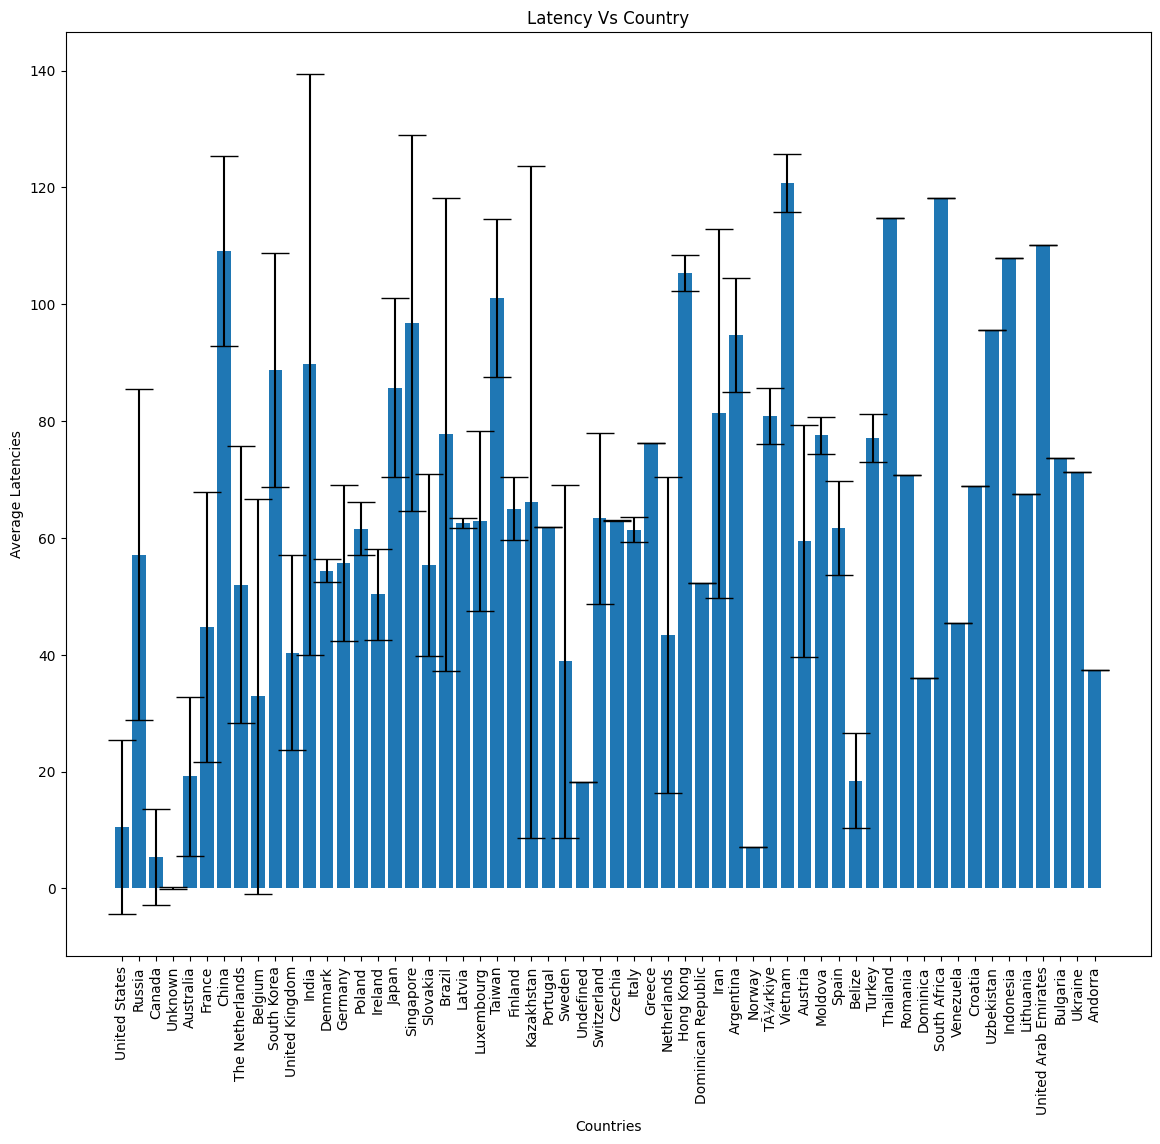

In [533]:
# first insight
analyzer.analyzeNetworkLatencyToCountries()

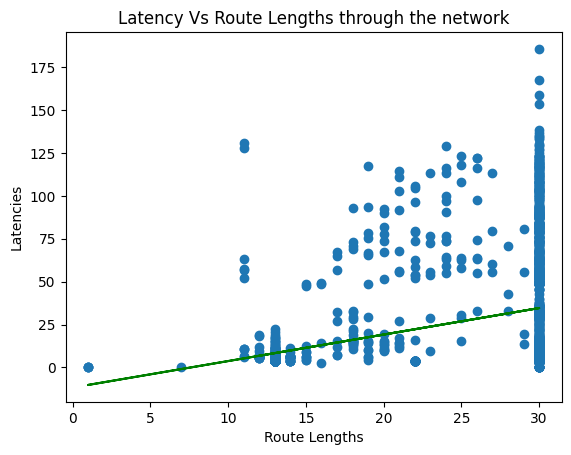

Correlation Between Route Lengths and Latencies : 0.3671251722343327
Standard Deviation for Route Lengths vs Latencies : 7.928572853339499
Most Typical Route Lengths : 30
Most Typical Latencies : 3.669
Covariance of Variables : 97.11795492837688
Median Latencies : 6.349


In [527]:
# second insight
analyzer.analyzeNetworkLatencyByRouteLength()

Beginning : Median = 0.21414285714285713 : Variance = 0.0769223112387344
FirstMiddle : Median = 1.4417142857142857 : Variance = 5.488583854911591
SecondMiddle : Median = 2.686 : Variance = 7.380808942308265
End : Median = 0 : Variance = 4.919027981714869


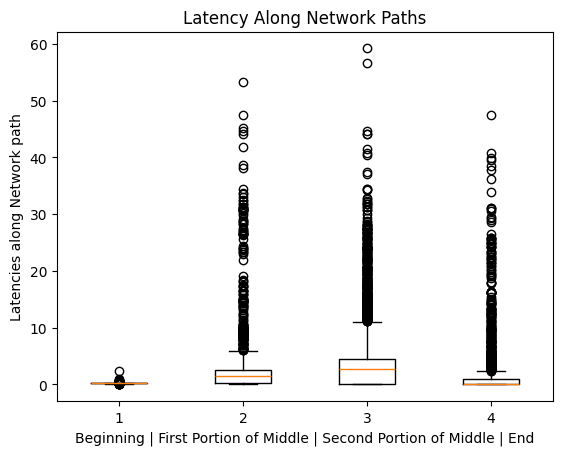

In [528]:
# third insight
analyzer.analyzeLatenciesAlongRoutes()

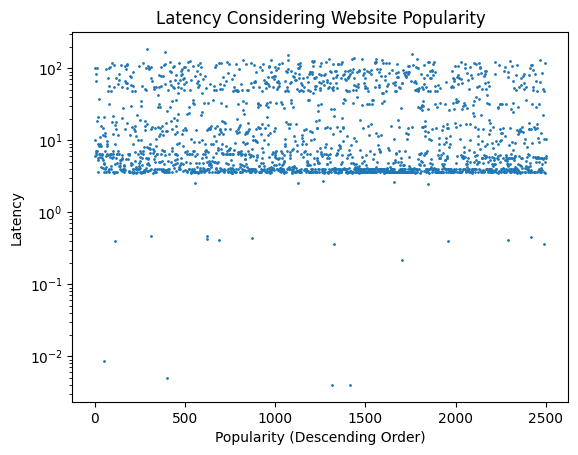

Correlation Between Popularity Rating and Latencies : -0.020834609672394047
Standard Deviation for Popularity Rating vs Latencies : 700.6345198819756
Most Typical Latencies : 3.669
Covariance of Variables : -487.04293030452413
Median Latencies : 6.349


In [529]:
# fourth insight
analyzer.analyzeLatencyAlongPopularity()

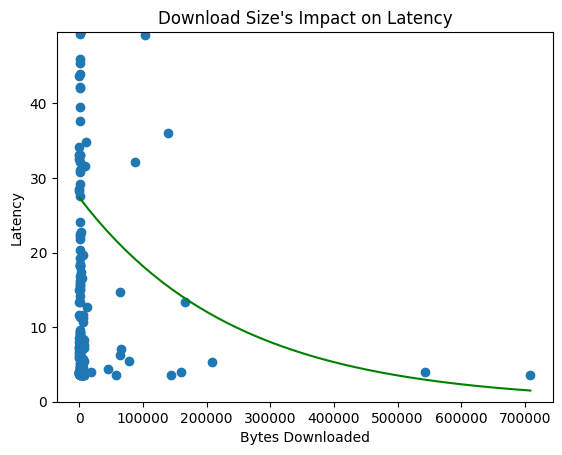

ALL BYTES
Correlation Between Downloaded Bytes and Latencies : -0.02075019073526586
Standard Deviation for Downloaded Bytes vs Latencies : 21845.352486042102
Most Typical Downloaded Bytes : 0
Most Typical Latencies : 3.669
Covariance of Variables : -15124.168037404312
Median Latencies : 6.349

First 3/4 BYTES
Correlation Between First 3/4 Downloaded Bytes and First 3/4 Latencies : -0.024537991068451247
Standard Deviation for First 3/4 Downloaded Bytes vs First 3/4 Latencies : 24475.653357753585
Most Typical First 3/4 Downloaded Bytes : 0
Most Typical First 3/4 Latencies : 3.669
Covariance of Variables : -20573.681552997965
Median First 3/4 Latencies : 6.433

Last 1/4 BYTES
Correlation Between Last 1/4 Downloaded Bytes and Last 1/4 Latencies : -0.0048822246106454414
Standard Deviation for Last 1/4 Downloaded Bytes vs Last 1/4 Latencies : 10575.007596602818
Most Typical Last 1/4 Downloaded Bytes : 0
Most Typical Last 1/4 Latencies : 3.6435
Covariance of Variables : -1566.5343409998447
Me

In [530]:
# fifth insight
analyzer.analyzeDownloadSizeAndLatency()